In [62]:
import warnings
warnings.filterwarnings('ignore')

In [63]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score, mean_squared_error

import statsmodels.api as sm

In [64]:
df = pd.read_csv('./bike-sharing.csv')
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [65]:
df.shape

(730, 16)

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [67]:
df.duplicated().sum()

0

In [68]:
df.drop(['instant', 'dteday','casual','registered','atemp'], axis=1, inplace=True)

In [69]:

df.shape

(730, 11)

In [70]:
categorical_variables = ['season','yr','mnth','holiday','weekday', 'workingday','weathersit']

# identify numeric variables
num_vars = ['temp', 'hum','windspeed','cnt']

In [71]:

df[categorical_variables] = df[categorical_variables].astype('category')

In [72]:

df.describe()

,temp,hum,windspeed,cnt
count,730.000000,730.000000,730.000000,730.000000
mean,20.319259,62.765175,12.763620,4508.006849
std,7.506729,14.237589,5.195841,1936.011647
min,2.424346,0.000000,1.500244,22.000000
25%,13.811885,52.000000,9.041650,3169.750000
50%,20.465826,62.625000,12.125325,4548.500000
75%,26.880615,72.989575,15.625589,5966.000000
max,35.328347,97.250000,34.000021,8714.000000


In [73]:
df.describe(include=['category'])

,season,yr,mnth,holiday,weekday,workingday,weathersit
count,730,730,730,730,730,730,730
unique,4,2,12,2,7,2,3
top,3,0,1,0,0,1,1
freq,188,365,62,709,105,499,463


In [74]:

df['season'] = df['season'].map({1:'spring', 2:'summer', 3:'fall', 4:'winter'})


df['weekday'] = df['weekday'].map({0: 'Sun', 1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat'})



df['mnth'] = df['mnth'].map({1:'jan', 2:'feb', 3:'mar', 4:'apr', 5: 'may', 6: 'jun', 7: 'jul', 8: 'aug', 9: 'sep', 10: 'oct',11: 'nov', 12:'dec'})


df['weathersit'] = df['weathersit'].map({1: 'Clear_FewClouds', 2: 'Mist_Cloudy', 3: 'LightSnow_LightRain', 4: 'HeavyRain_IcePallets'})

In [75]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      730 non-null    category
 1   yr          730 non-null    category
 2   mnth        730 non-null    category
 3   holiday     730 non-null    category
 4   weekday     730 non-null    category
 5   workingday  730 non-null    category
 6   weathersit  730 non-null    category
 7   temp        730 non-null    float64 
 8   hum         730 non-null    float64 
 9   windspeed   730 non-null    float64 
 10  cnt         730 non-null    int64   
dtypes: category(7), float64(3), int64(1)
memory usage: 29.4 KB


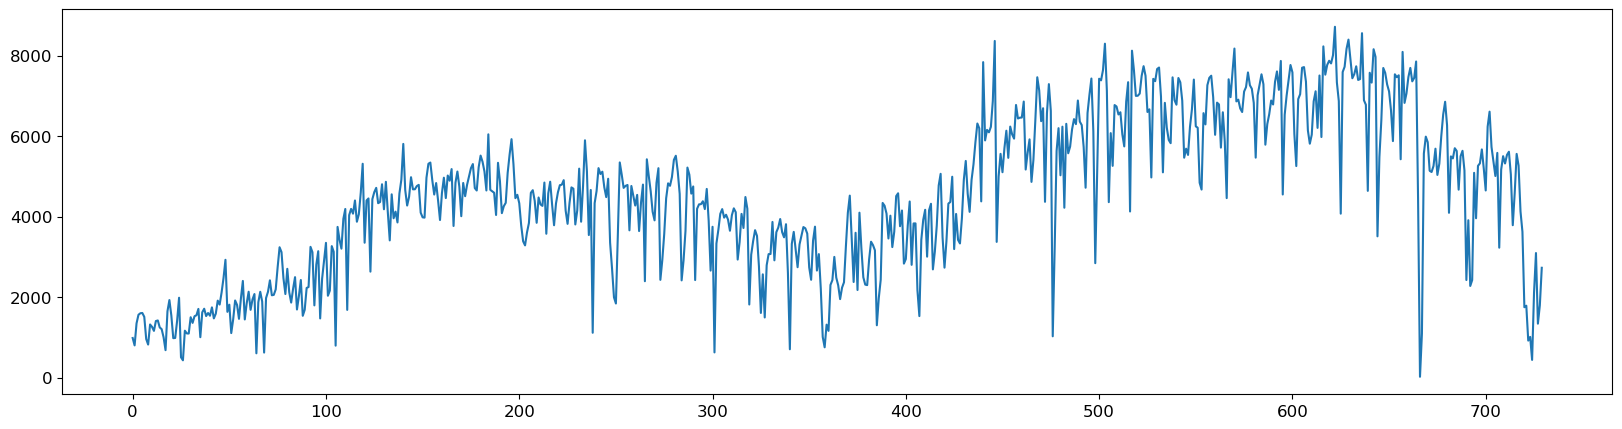

In [76]:
plt.figure(figsize=(20,5))
plt.plot(df.cnt)
plt.show()

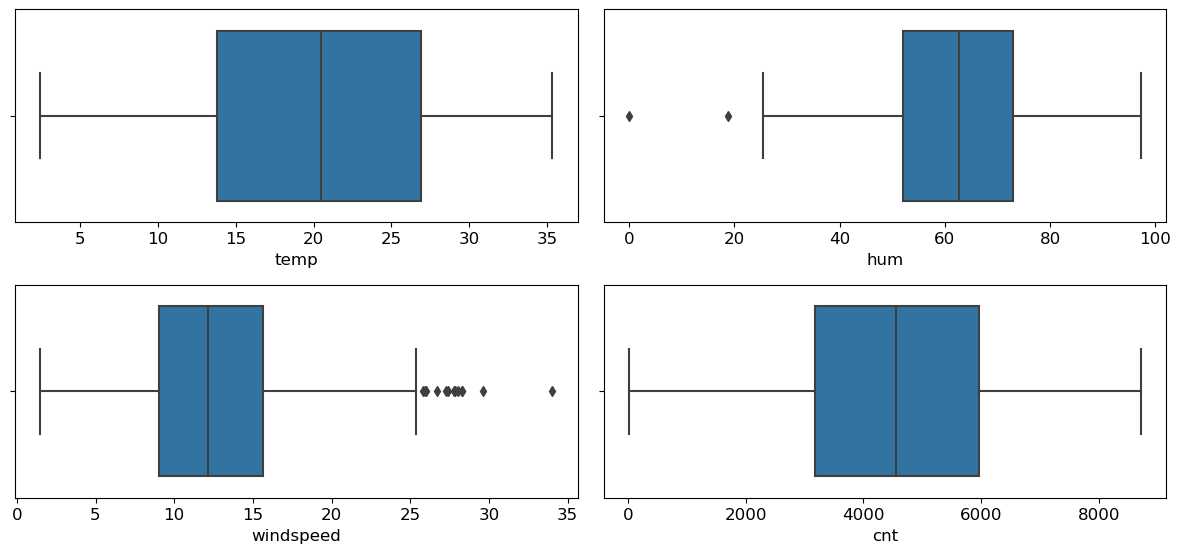

In [77]:
var = df.select_dtypes(exclude = 'category').columns

# Box plot
col = 2
row = len(var)//col+1

plt.figure(figsize=(12,8))
plt.rc('font', size=12)
for i in list(enumerate(var)):
    plt.subplot(row, col, i[0]+1)
    sns.boxplot(df[i[1]])    
plt.tight_layout()   
plt.show()

In [78]:
def percentage_outlier(x):
    iqr = df[x].quantile(0.75)-df[x].quantile(0.25)
    HL = df[x].quantile(0.75)+iqr*1.5
    LL = df[x].quantile(0.25)-iqr*1.5
    per_outlier = ((df[x]<LL).sum()+(df[x]>HL).sum())/len(df[x])*100
    per_outlier = round(per_outlier,2)
    return(per_outlier)

print('Percentage of outlier (hum): ', percentage_outlier('hum'))
print('Percentage of outlier (windspeed): ', percentage_outlier('windspeed'))

Percentage of outlier (hum):  0.27
Percentage of outlier (windspeed):  1.78


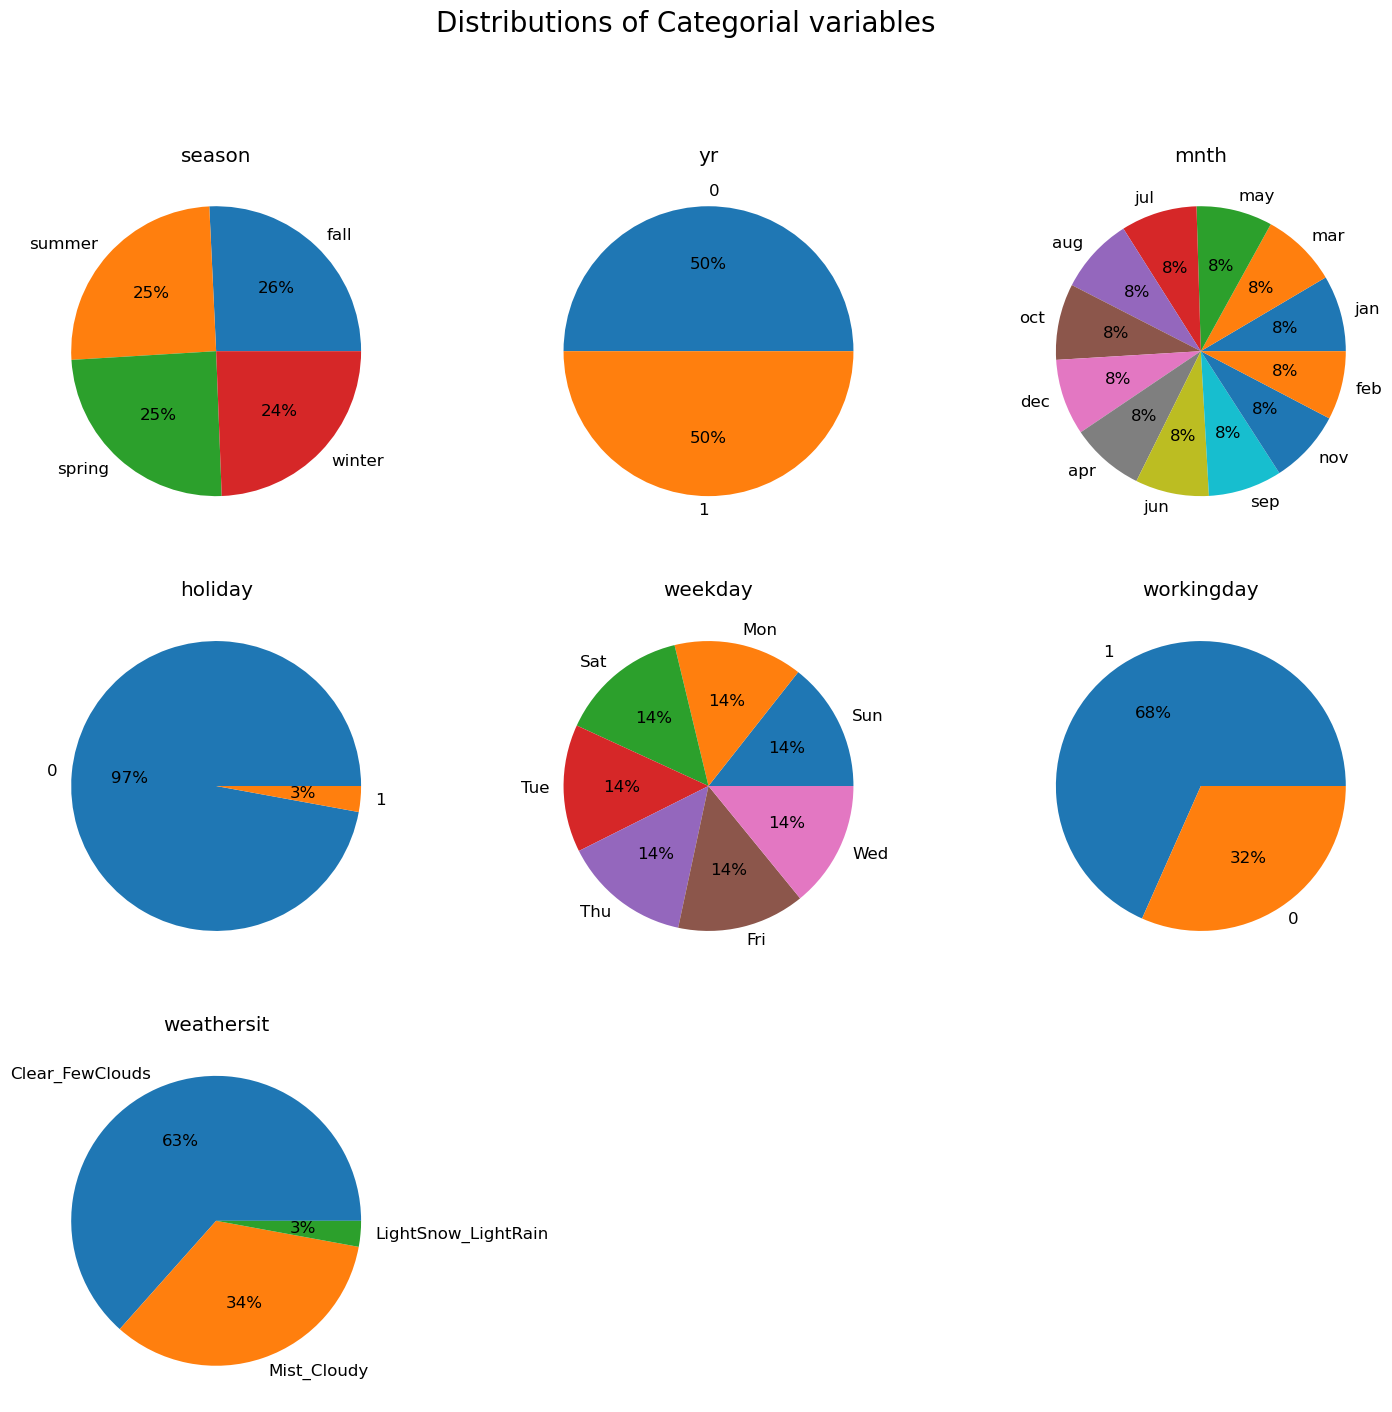

In [79]:
df_pie_plot=df.select_dtypes(include='category')
plt.figure(figsize=(18,16))
plt.suptitle('Distributions of Categorial variables', fontsize=20)
for i in range(1,df_pie_plot.shape[1]+1):
    plt.subplot(3,3,i)
    f=plt.gca()
    f.set_title(df_pie_plot.columns.values[i-1])
    values=df_pie_plot.iloc[:,i-1].value_counts(normalize=True).values
    index=df_pie_plot.iloc[:,i-1].value_counts(normalize=True).index
    plt.pie(values,labels=index,autopct='%1.0f%%')
plt.show()

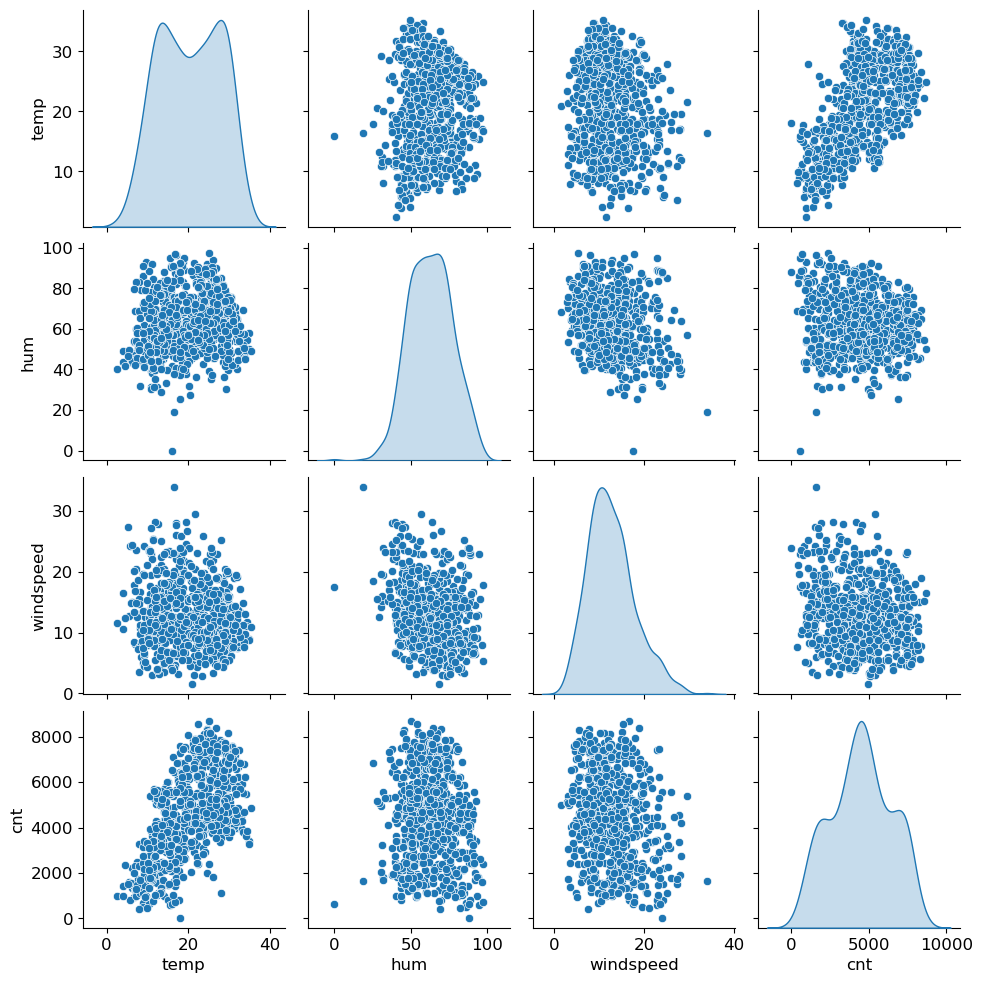

In [80]:

sns.pairplot(df.select_dtypes(['int64','float64']), diag_kind='kde')
plt.show()

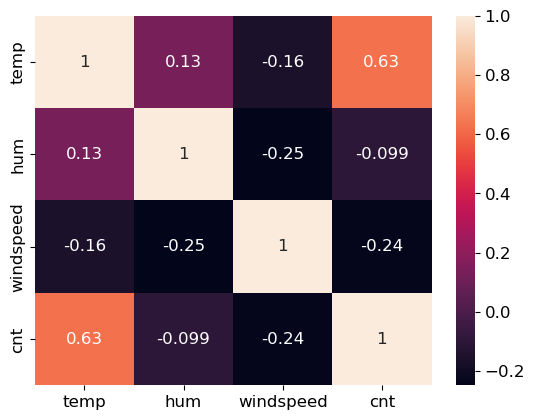

In [81]:
corr_mat=df.corr()
sns.heatmap(corr_mat, annot=True)
plt.show()

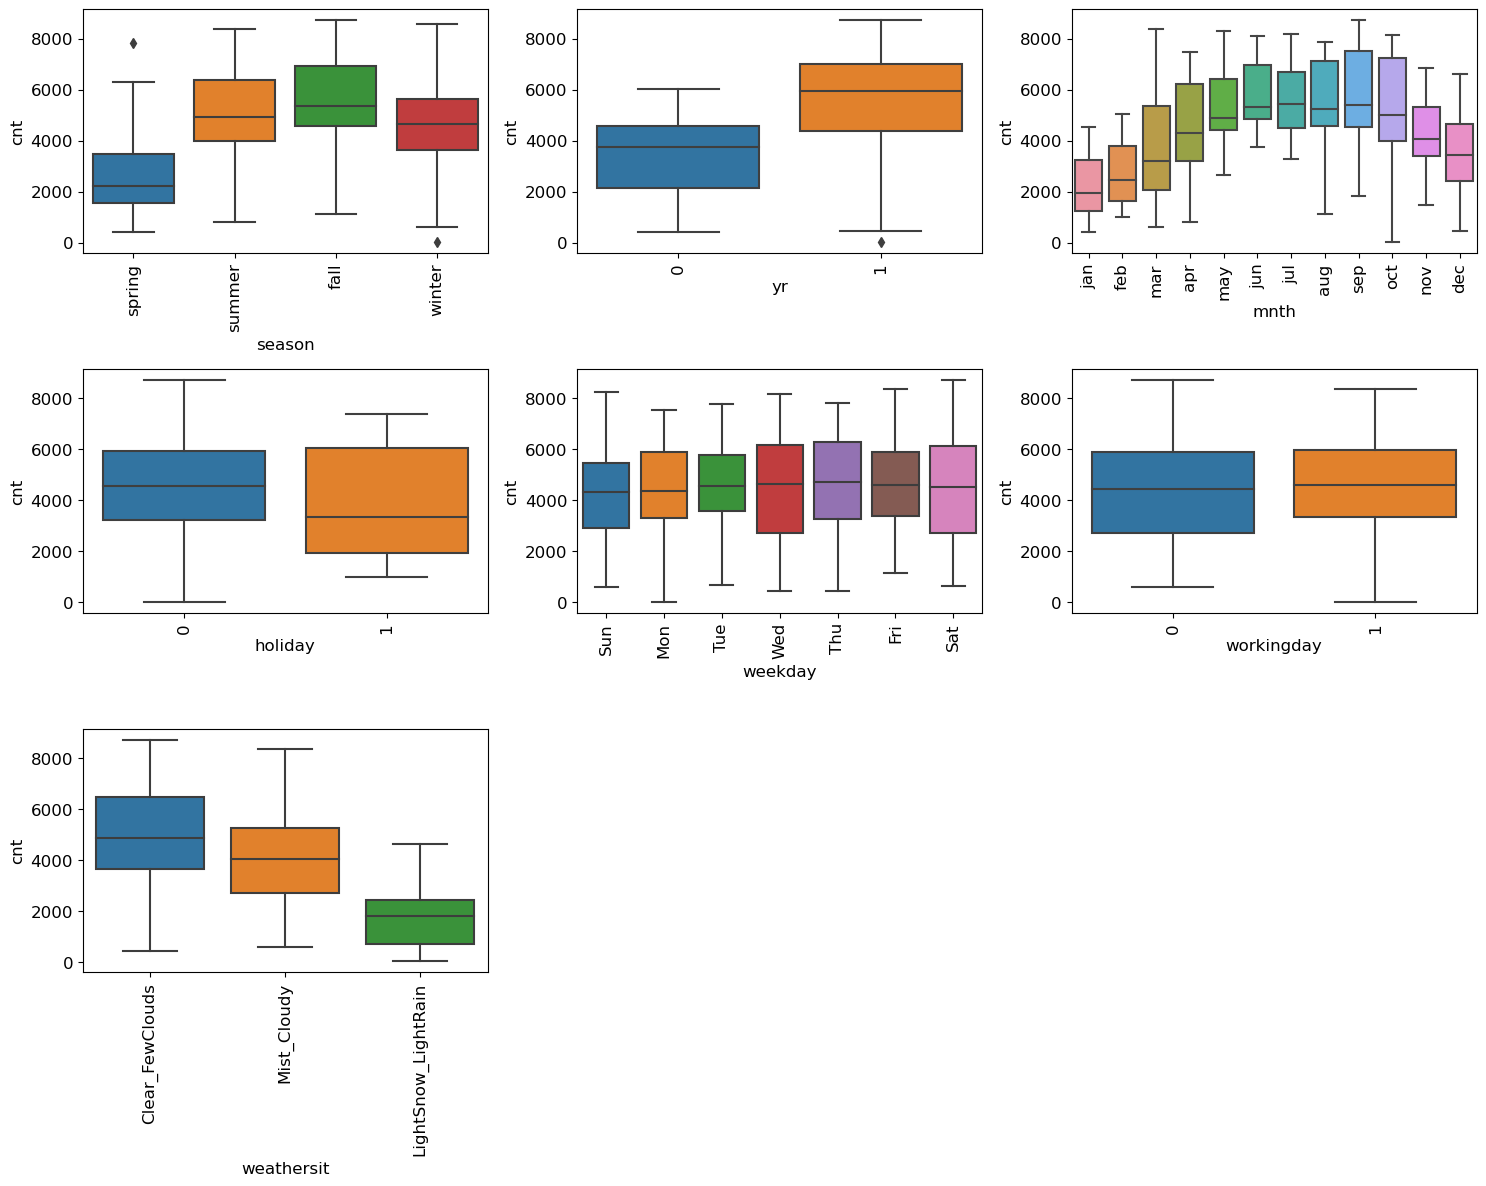

In [82]:

col = 3
row = len(categorical_variables) // col+1

plt.figure(figsize=(15,12))
for i in list(enumerate(categorical_variables)):
    plt.subplot(row,col,i[0]+1)
    sns.boxplot(x = i[1], y = 'cnt', data = df)
    plt.xticks(rotation = 90)
plt.tight_layout(pad = 1)    
plt.show()

In [83]:

dummy_vars = pd.get_dummies(df[['season','weekday','mnth','weathersit']],drop_first=True)


df = pd.concat([df,dummy_vars], axis = 1)


df.drop(['season','weekday','mnth','weathersit'], axis=1, inplace=True)

df.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,season_summer,season_fall,season_winter,...,mnth_may,mnth_jun,mnth_jul,mnth_aug,mnth_sep,mnth_oct,mnth_nov,mnth_dec,weathersit_Mist_Cloudy,weathersit_LightSnow_LightRain
0,0,0,0,14.110847,80.5833,10.749882,985,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,14.902598,69.6087,16.652113,801,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,1,8.050924,43.7273,16.636703,1349,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,8.200000,59.0435,10.739832,1562,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,9.305237,43.6957,12.522300,1600,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [84]:

df.shape


(730, 29)

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   yr                              730 non-null    category
 1   holiday                         730 non-null    category
 2   workingday                      730 non-null    category
 3   temp                            730 non-null    float64 
 4   hum                             730 non-null    float64 
 5   windspeed                       730 non-null    float64 
 6   cnt                             730 non-null    int64   
 7   season_summer                   730 non-null    uint8   
 8   season_fall                     730 non-null    uint8   
 9   season_winter                   730 non-null    uint8   
 10  weekday_Mon                     730 non-null    uint8   
 11  weekday_Tue                     730 non-null    uint8   
 12  weekday_Wed           

In [86]:
df[['yr','holiday','workingday']]= df[['yr','holiday','workingday']].astype('uint8')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   yr                              730 non-null    uint8  
 1   holiday                         730 non-null    uint8  
 2   workingday                      730 non-null    uint8  
 3   temp                            730 non-null    float64
 4   hum                             730 non-null    float64
 5   windspeed                       730 non-null    float64
 6   cnt                             730 non-null    int64  
 7   season_summer                   730 non-null    uint8  
 8   season_fall                     730 non-null    uint8  
 9   season_winter                   730 non-null    uint8  
 10  weekday_Mon                     730 non-null    uint8  
 11  weekday_Tue                     730 non-null    uint8  
 12  weekday_Wed                     730 

In [87]:
df_train, df_test = train_test_split(df, train_size = 0.7, random_state = 10 )
print(df_train.shape)
print(df_test.shape)

(510, 29)
(220, 29)


In [88]:

scaler = MinMaxScaler()

df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_train.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,season_summer,season_fall,season_winter,...,mnth_may,mnth_jun,mnth_jul,mnth_aug,mnth_sep,mnth_oct,mnth_nov,mnth_dec,weathersit_Mist_Cloudy,weathersit_LightSnow_LightRain
72,0,0,1,0.298094,0.393891,0.236118,0.194978,0,0,0,...,0,0,0,0,0,0,0,0,0,0
510,1,0,0,0.778657,0.694105,0.364071,0.737052,1,0,0,...,1,0,0,0,0,0,0,0,0,0
700,1,0,0,0.327249,0.809877,0.210252,0.509236,0,0,1,...,0,0,0,0,0,0,0,1,1,0
264,0,0,1,0.694699,0.910249,0.217975,0.526862,0,1,0,...,0,0,0,0,1,0,0,0,1,0
577,1,0,1,0.811368,0.624004,0.244886,0.863093,0,1,0,...,0,0,0,1,0,0,0,0,0,0


**Testing data scaling**

In [89]:

df_test.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,season_summer,season_fall,season_winter,...,mnth_may,mnth_jun,mnth_jul,mnth_aug,mnth_sep,mnth_oct,mnth_nov,mnth_dec,weathersit_Mist_Cloudy,weathersit_LightSnow_LightRain
566,1,0,0,24.429153,86.5417,14.291100,4459,0,1,0,...,0,0,1,0,0,0,0,0,0,1
374,1,0,1,12.656536,64.6522,12.565984,3598,0,0,0,...,0,0,0,0,0,0,0,0,0,0
181,0,0,1,29.622500,39.6250,6.874736,5362,0,1,0,...,0,0,1,0,0,0,0,0,0,0
529,1,0,1,26.581653,56.9583,17.000111,7363,1,0,0,...,0,1,0,0,0,0,0,0,0,0
233,0,0,1,28.358347,47.0000,18.542250,4758,0,1,0,...,0,0,0,1,0,0,0,0,0,0


In [90]:
# transform test dataset 
df_test[num_vars] = scaler.transform(df_test[num_vars])
df_test.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,season_summer,season_fall,season_winter,...,mnth_may,mnth_jun,mnth_jul,mnth_aug,mnth_sep,mnth_oct,mnth_nov,mnth_dec,weathersit_Mist_Cloudy,weathersit_LightSnow_LightRain
566,1,0,0,0.652175,0.863516,0.393568,0.486297,0,1,0,...,0,0,1,0,0,0,0,0,0,1
374,1,0,1,0.276477,0.584521,0.340487,0.382349,0,0,0,...,0,0,0,0,0,0,0,0,0,0
181,0,0,1,0.817910,0.265533,0.165370,0.595316,0,1,0,...,0,0,1,0,0,0,0,0,0,0
529,1,0,1,0.720868,0.486457,0.476922,0.836895,1,0,0,...,0,1,0,0,0,0,0,0,0,0
233,0,0,1,0.777567,0.359532,0.524373,0.522395,0,1,0,...,0,0,0,1,0,0,0,0,0,0


### 3.4 Split data set into X and y sets (for both train and test set)

In [91]:
y_train = df_train.pop('cnt')
X_train = df_train
X_train.head()

,yr,holiday,workingday,temp,hum,windspeed,season_summer,season_fall,season_winter,weekday_Mon,...,mnth_may,mnth_jun,mnth_jul,mnth_aug,mnth_sep,mnth_oct,mnth_nov,mnth_dec,weathersit_Mist_Cloudy,weathersit_LightSnow_LightRain
72,0,0,1,0.298094,0.393891,0.236118,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
510,1,0,0,0.778657,0.694105,0.364071,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
700,1,0,0,0.327249,0.809877,0.210252,0,0,1,0,...,0,0,0,0,0,0,0,1,1,0
264,0,0,1,0.694699,0.910249,0.217975,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
577,1,0,1,0.811368,0.624004,0.244886,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0


In [92]:
y_test = df_test.pop('cnt')
X_test = df_test

X_test.head()

,yr,holiday,workingday,temp,hum,windspeed,season_summer,season_fall,season_winter,weekday_Mon,...,mnth_may,mnth_jun,mnth_jul,mnth_aug,mnth_sep,mnth_oct,mnth_nov,mnth_dec,weathersit_Mist_Cloudy,weathersit_LightSnow_LightRain
566,1,0,0,0.652175,0.863516,0.393568,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
374,1,0,1,0.276477,0.584521,0.340487,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
181,0,0,1,0.817910,0.265533,0.165370,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
529,1,0,1,0.720868,0.486457,0.476922,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
233,0,0,1,0.777567,0.359532,0.524373,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0


### Data Modeling and Evaluation

### Recusive feature elemination (RFE)

In [93]:
X_train.columns

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed',
       'season_summer', 'season_fall', 'season_winter', 'weekday_Mon',
       'weekday_Tue', 'weekday_Wed', 'weekday_Thu', 'weekday_Fri',
       'weekday_Sat', 'mnth_feb', 'mnth_mar', 'mnth_apr', 'mnth_may',
       'mnth_jun', 'mnth_jul', 'mnth_aug', 'mnth_sep', 'mnth_oct', 'mnth_nov',
       'mnth_dec', 'weathersit_Mist_Cloudy', 'weathersit_LightSnow_LightRain'],
      dtype='object')

In [94]:
lm = LinearRegression()
rfe = RFE(lm)
rfe = rfe.fit(X_train, y_train)


col = X_train.columns[rfe.support_]
col

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed',
       'season_winter', 'weekday_Mon', 'weekday_Tue', 'weekday_Wed',
       'weekday_Thu', 'weekday_Fri', 'mnth_sep',
       'weathersit_LightSnow_LightRain'],
      dtype='object')

In [95]:
X_train_rfe = X_train[col]

In [96]:
def sm_linearmodel(X_train_sm):
    X_train_sm = sm.add_constant(X_train_sm)

    lm = sm.OLS(y_train,X_train_sm).fit()
    return lm

In [97]:
def vif_calc(X):
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'],2)
    vif = vif.sort_values(by='VIF', ascending = False)
    return vif

In [98]:
lm_1 = sm_linearmodel(X_train_rfe)
print(lm_1.summary())

print(vif_calc(X_train_rfe))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     156.5
Date:                Thu, 23 Mar 2023   Prob (F-statistic):          4.98e-166
Time:                        10:29:44   Log-Likelihood:                 428.39
No. Observations:                 510   AIC:                            -828.8
Df Residuals:                     496   BIC:                            -769.5
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [99]:
pvalue = lm_1.pvalues
while(max(pvalue)>0.05):
    maxp_var = pvalue[pvalue == pvalue.max()].index
    print('Removed variable:' , maxp_var[0], '    P value: ', round(max(pvalue),3))
    
    # dropping variable with high p value
    X_train_rfe = X_train_rfe.drop(maxp_var, axis = 1)
    lm_1 = sm_linearmodel(X_train_rfe)
    pvalue = lm_1.pvalues
    
    

Removed variable: weekday_Fri     P value:  0.861
Removed variable: weekday_Wed     P value:  0.954
Removed variable: weekday_Thu     P value:  0.631
Removed variable: weekday_Tue     P value:  0.512
Removed variable: workingday     P value:  0.576
Removed variable: weekday_Mon     P value:  0.09


In [100]:
print(lm_1.summary())

print(vif_calc(X_train_rfe))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     254.4
Date:                Thu, 23 Mar 2023   Prob (F-statistic):          4.88e-171
Time:                        10:29:44   Log-Likelihood:                 426.42
No. Observations:                 510   AIC:                            -834.8
Df Residuals:                     501   BIC:                            -796.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [101]:
X_train_new = X_train_rfe.drop(['hum'],axis = 1)

lm_2 = sm_linearmodel(X_train_new)
print(lm_2.summary())

print(vif_calc(X_train_new))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     247.0
Date:                Thu, 23 Mar 2023   Prob (F-statistic):          4.07e-158
Time:                        10:29:44   Log-Likelihood:                 393.19
No. Observations:                 510   AIC:                            -770.4
Df Residuals:                     502   BIC:                            -736.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [102]:

lm_3 = sm_linearmodel(X_train_new)
print(lm_3.summary())


print(vif_calc(X_train_new))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     247.0
Date:                Thu, 23 Mar 2023   Prob (F-statistic):          4.07e-158
Time:                        10:29:44   Log-Likelihood:                 393.19
No. Observations:                 510   AIC:                            -770.4
Df Residuals:                     502   BIC:                            -736.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [103]:

lm_4 = sm_linearmodel(X_train_new)
print(lm_4.summary())

print(vif_calc(X_train_new))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     247.0
Date:                Thu, 23 Mar 2023   Prob (F-statistic):          4.07e-158
Time:                        10:29:44   Log-Likelihood:                 393.19
No. Observations:                 510   AIC:                            -770.4
Df Residuals:                     502   BIC:                            -736.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [104]:

lm_5 = sm_linearmodel(X_train_new)
print(lm_5.summary())


print(vif_calc(X_train_new))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     247.0
Date:                Thu, 23 Mar 2023   Prob (F-statistic):          4.07e-158
Time:                        10:29:44   Log-Likelihood:                 393.19
No. Observations:                 510   AIC:                            -770.4
Df Residuals:                     502   BIC:                            -736.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [105]:

lm_final = lm_5


var_final = list(lm_final.params.index)
var_final.remove('const')
print('Final Selected Variables:', var_final)


print('\033[1m{:10s}\033[0m'.format('\nCoefficent for the variables are:'))
print(round(lm_final.params,3))

Final Selected Variables: ['yr', 'holiday', 'temp', 'windspeed', 'season_winter', 'mnth_sep', 'weathersit_LightSnow_LightRain']

Coefficent for the variables are:
const                             0.076
yr                                0.254
holiday                          -0.097
temp                              0.597
windspeed                        -0.122
season_winter                     0.109
mnth_sep                          0.049
weathersit_LightSnow_LightRain   -0.232
dtype: float64


In [106]:
X_train_res = X_train[var_final]

In [107]:
X_train_res = sm.add_constant(X_train_res)

y_train_pred = lm_final.predict(X_train_res)

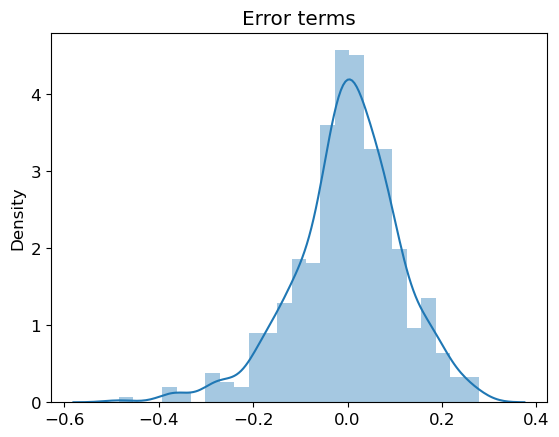

In [108]:
res = y_train - y_train_pred
sns.distplot(res)
plt.title('Error terms')
plt.show()

Text(0, 0.5, 'Residual')

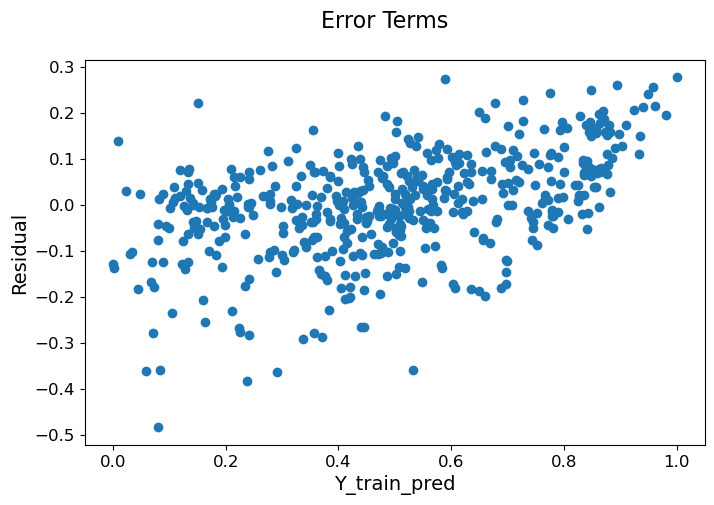

In [109]:
c = [i for i in range(1,len(y_train)+1,1)]
fig = plt.figure(figsize=(8,5))
plt.scatter(y_train,res)
fig.suptitle('Error Terms', fontsize=16)              # Plot heading 
plt.xlabel('Y_train_pred', fontsize=14)                      # X-label
plt.ylabel('Residual', fontsize=14)   

### Prediction on test set

In [110]:
df_test.head()

,yr,holiday,workingday,temp,hum,windspeed,season_summer,season_fall,season_winter,weekday_Mon,...,mnth_may,mnth_jun,mnth_jul,mnth_aug,mnth_sep,mnth_oct,mnth_nov,mnth_dec,weathersit_Mist_Cloudy,weathersit_LightSnow_LightRain
566,1,0,0,0.652175,0.863516,0.393568,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
374,1,0,1,0.276477,0.584521,0.340487,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
181,0,0,1,0.817910,0.265533,0.165370,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
529,1,0,1,0.720868,0.486457,0.476922,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
233,0,0,1,0.777567,0.359532,0.524373,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0


In [111]:
X_test_sm = X_test[var_final]
X_test_sm.head()

,yr,holiday,temp,windspeed,season_winter,mnth_sep,weathersit_LightSnow_LightRain
566,1,0,0.652175,0.393568,0,0,1
374,1,0,0.276477,0.340487,0,0,0
181,0,0,0.817910,0.165370,0,0,0
529,1,0,0.720868,0.476922,0,0,0
233,0,0,0.777567,0.524373,0,0,0


In [112]:
X_test_sm = sm.add_constant(X_test_sm)
X_test_sm.head()

,const,yr,holiday,temp,windspeed,season_winter,mnth_sep,weathersit_LightSnow_LightRain
566,1.0,1,0,0.652175,0.393568,0,0,1
374,1.0,1,0,0.276477,0.340487,0,0,0
181,1.0,0,0,0.817910,0.165370,0,0,0
529,1.0,1,0,0.720868,0.476922,0,0,0
233,1.0,0,0,0.777567,0.524373,0,0,0


In [113]:
y_test_pred = lm_final.predict(X_test_sm)

###  Evaluate the model on test set

In [114]:
r2_test = r2_score(y_true = y_test, y_pred = y_test_pred)
print('R-Squared for Test dataset: ', round(r2_test,3))

R-Squared for Test dataset:  0.774


In [115]:
N= len(X_test)          # sample size
p =len(var_final)     # Number of independent variable
r2_test_adj = round((1-((1-r2_test)*(N-1)/(N-p-1))),3)
print('Adj. R-Squared for Test dataset: ', round(r2_test_adj,3))

Adj. R-Squared for Test dataset:  0.766


In [116]:
mse = mean_squared_error(y_test, y_test_pred)
print('Mean_Squared_Error :' ,round(mse,4))

Mean_Squared_Error : 0.0117


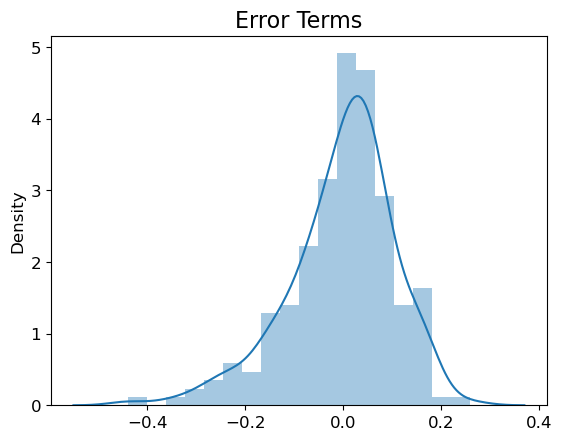

In [117]:
res_test = y_test - y_test_pred
plt.title('Error Terms', fontsize=16) 
sns.distplot(res_test)
plt.show()

Text(0, 0.5, 'Residual')

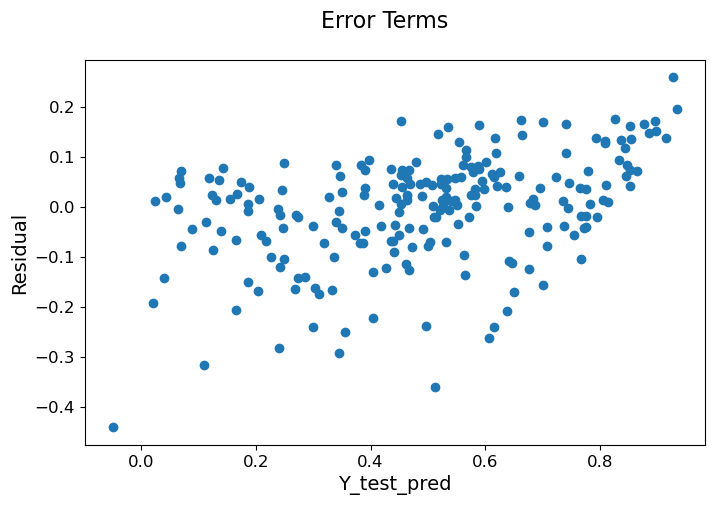

In [118]:
c = [i for i in range(1,len(y_test)+1,1)]
fig = plt.figure(figsize=(8,5))
plt.scatter(y_test,res_test)
fig.suptitle('Error Terms', fontsize=16)              # Plot heading 
plt.xlabel('Y_test_pred', fontsize=14)                      # X-label
plt.ylabel('Residual', fontsize=14)   

- It seems like the corresponding residual plot is reasonably random.

Text(0, 0.5, 'y_test_pred')

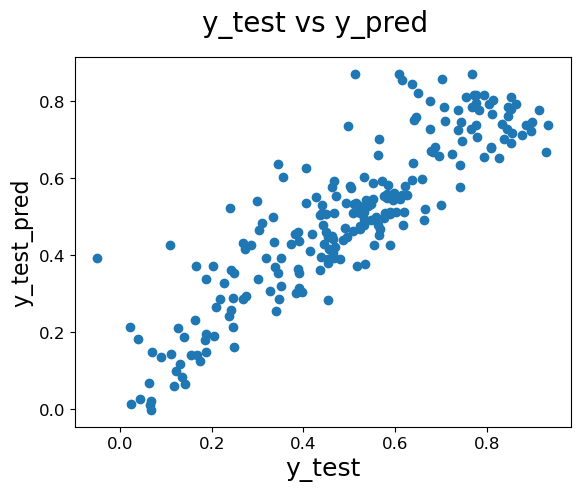

In [119]:
fig = plt.figure()
plt.scatter(y_test, y_test_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_test_pred', fontsize = 16)      

In [120]:
print('R- Sqaured train: ', round(lm_final.rsquared,2), '  Adj. R-Squared train:', round(lm_final.rsquared_adj,3) )
print('R- Sqaured test : ', round(r2_test,2), '  Adj. R-Squared test :', round(r2_test_adj,3))

print('\033[1m{:10s}\033[0m'.format('\nCoefficent for the variables are:'))
print(round(lm_final.params,3))

R- Sqaured train:  0.77   Adj. R-Squared train: 0.772
R- Sqaured test :  0.77   Adj. R-Squared test : 0.766

Coefficent for the variables are:
const                             0.076
yr                                0.254
holiday                          -0.097
temp                              0.597
windspeed                        -0.122
season_winter                     0.109
mnth_sep                          0.049
weathersit_LightSnow_LightRain   -0.232
dtype: float64
